# Predicting Pokemon Types from Images and Statistics

Scott Ratchford, (c) 2025

See `LICENSE.txt` for license information.

## Setup

### Constants and Parameters

In [1]:
# Set paths to data files and directories

import os
import pandas as pd
import numpy as np

CWD = os.getcwd()

# Input paths for data
POKEDEX_PATH = os.path.join(CWD, "data", "pokemon_images", "pokedex.csv")   # Modified .csv file from "Pokemon with Stats and Images"
PKMN_STATS_PATH = os.path.join(CWD, "data", "pokemon_stats.csv")            # .csv file from "Pokemon Pokedex"

# Output paths for created and modified data
PKMN_IMG_COLORS_PATH = os.path.join(CWD, "pokemon_colors.csv")              # Pokemon color data output

RNG_SEED = 151

### Import Datasets

In [2]:
from sklearn.preprocessing import LabelEncoder

# Import in-game statistics dataset
pkmn_stats = pd.read_csv(POKEDEX_PATH, encoding="utf-8")
size_before = pkmn_stats.shape[0]

# Drop ignored rows
pkmn_stats = pkmn_stats[pkmn_stats["Ignore"] == False]
print(f"Dropped {size_before - pkmn_stats.shape[0]} ignored Pokemon. See README.md for details.")

print(f"PKMN stats rows: {pkmn_stats.shape[0]}")
print(f"PKMN stats columns: {list(pkmn_stats.columns)}")

# Set Name to lowercase
pkmn_stats["Name"] = pkmn_stats["Name"].apply(lambda x: x.lower())

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
pkmn_stats["Type 1"] = type_label_encoder.fit_transform(pkmn_stats["Type 1"])
pkmn_stats["Type 1"] = pkmn_stats["Type 1"].astype(dtype=int)
pkmn_stats["Type 2"] = type_label_encoder.fit_transform(pkmn_stats["Type 2"])
pkmn_stats["Type 2"] = pkmn_stats["Type 2"].astype(dtype=int)

# Change NaN values to "None"
pkmn_stats["Type 2"] = pkmn_stats["Type 2"].apply(lambda x: x if pd.notna(x) else "None")

# Import image colors dataset
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_PATH, encoding="utf-8", index_col=0)
print(f"PKMN color rows: {pkmn_color_df.shape[0]}")
print(f"PKMN colors columns: {list(pkmn_color_df.columns)}")

# Add Number and Train columns to pkmn_stats
pkmn_stats = pd.merge(pkmn_stats, pkmn_color_df[["Name", "Number", "Train"]], on=["Name", ], how="inner")

Dropped 232 ignored Pokemon. See README.md for details.
PKMN stats rows: 983
PKMN stats columns: ['Index', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'SP. Atk.', 'SP. Def', 'Speed', 'Ignore', 'Filename']
PKMN color rows: 959
PKMN colors columns: ['Name', 'Type 1', 'Type 2', 'Filename', 'Number', 'Train', 'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange']


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Drop columns that provide too much or unneeded information about the Pokemon
drop_stats_cols = ["Name", "Ignore", "Filename", "Number", "Train", ]

pkmn_stats_train = pkmn_stats[pkmn_stats["Train"] == True]
pkmn_stats_test = pkmn_stats[pkmn_stats["Train"] == False]

X_stats_train = pkmn_stats_train.drop(labels=(drop_stats_cols + ["Type 1", "Type 2", ]), axis=1)
X_stats_test = pkmn_stats_test.drop(labels=(drop_stats_cols + ["Type 1", "Type 2", ]), axis=1)
y_stats_train = pkmn_stats_train[["Type 1", "Type 2", ]].copy()
y_stats_test = pkmn_stats_test[["Type 1", "Type 2", ]].copy()

print(f"Split Pokemon statistics into {X_stats_train.shape[0]} training and {X_stats_test.shape[0]} testing.")

Split Pokemon statistics into 767 training and 192 testing.


## Helper Functions

In [15]:
def either_correct(pred: tuple[str, str], true: tuple[str, str]) -> bool:
    for p in pred:
        if p == "None":
            continue
        if p in true:
            return True
    
    return False

def both_correct(pred: tuple[str, str], true: tuple[str, str]) -> bool:
    if len(pred) != 2 or len(true) != 2:
        raise ValueError("Length of pred and true must each be 2.")
    pred_set = set(pred)
    if "None" in pred:
        pred_set.remove("None")
        
    return pred_set.intersection(set(true)) == set(pred)

def get_either_correct(pred: pd.DataFrame, true: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(pred, true, how="left", left_index=True, right_index=True)
    df["either"] = df.apply(lambda x: either_correct((x["Type 1"], x["Type 2"]), (x["Type 1 Pred"], x["Type 2 Pred"])), axis=1)

    return df

def get_both_correct(pred: pd.DataFrame, true: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(pred, true, how="left", left_index=True, right_index=True)
    df["both"] = df.apply(lambda x: both_correct((x["Type 1"], x["Type 2"]), (x["Type 1 Pred"], x["Type 2 Pred"])), axis=1)

    return df

def either_accuracy_score(pred: pd.DataFrame, true: pd.DataFrame) -> float:
    return get_either_correct(pred, true)["either"].mean()

def both_accuracy_score(pred: pd.DataFrame, true: pd.DataFrame) -> float:
    return get_both_correct(pred, true)["both"].mean()

## Multi-Label Type Classification Based on In-Game Statistics

These models use in-game statistics to predict the values of `Type 1` and `Type 2`.

### K-Nearest Neighbors

In [5]:
# Create the KNN model for in-game statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
knn_stats_hyperparameters = [
    {
        "estimator__n_neighbors": range(3, 11),
        "estimator__leaf_size": range(10, 41),
        "estimator__p": range(1, 4),
        "estimator__weights": ("distance", "uniform", ),
        "estimator__algorithm": ("kd_tree", "ball_tree", ),
    },
]

knn_stats_search = GridSearchCV(
    estimator=MultiOutputClassifier(KNeighborsClassifier()),
    param_grid=knn_stats_hyperparameters,
    cv = 5
)
knn_stats_model = knn_stats_search.fit(X_stats_train, y_stats_train)

print(knn_stats_model.best_params_)

{'estimator__algorithm': 'kd_tree', 'estimator__leaf_size': 10, 'estimator__n_neighbors': 10, 'estimator__p': 1, 'estimator__weights': 'distance'}


In [16]:
knn_stats_pred = pd.DataFrame(knn_stats_model.predict(X_stats_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(knn_stats_pred, y_stats_test)
acc_both = both_accuracy_score(knn_stats_pred, y_stats_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.09895833333333333
Both type accuracy: 0.010416666666666666


### Decision Tree

In [23]:
# Create the DT model for in-game statistics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_stats_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": range(6, 14, 2),
        "estimator__min_samples_split": (2, 6, 10, ),
        "estimator__min_samples_leaf": range(8, 20, 2),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_stats_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_stats_hyperparameters,
    cv = 5
)
dt_stats_model = dt_stats_search.fit(X_stats_train, y_stats_train)

print(dt_stats_model.best_params_)

{'estimator__criterion': 'gini', 'estimator__max_depth': 6, 'estimator__min_samples_leaf': 14, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [24]:
dt_stats_pred = pd.DataFrame(dt_stats_model.predict(X_stats_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_stats_pred, y_stats_test)
acc_both = both_accuracy_score(dt_stats_pred, y_stats_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.078125
Both type accuracy: 0.005208333333333333


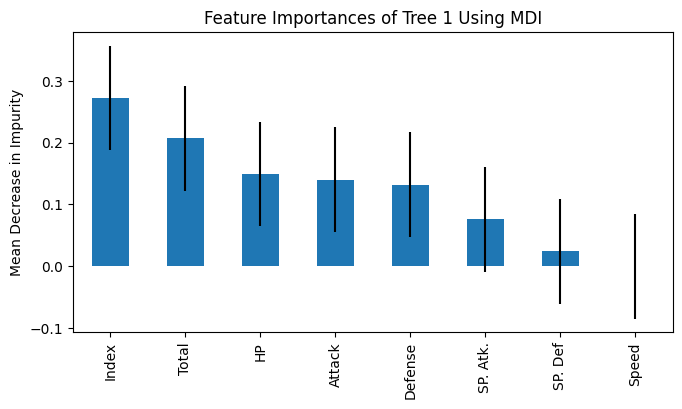

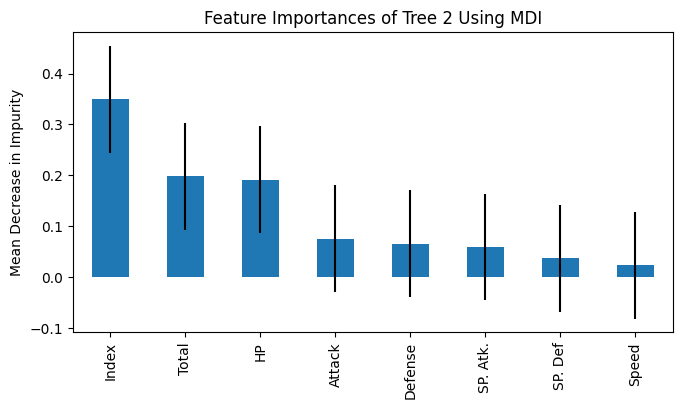

In [60]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_stats_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_stats_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

## Multi-Label Type Classification Based on Image Colors

### Load Image Colors with Type 1 and Type 2

In [40]:
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_PATH, sep=",", encoding="utf-8", index_col=0)

pkmn_color_train_df = pkmn_color_df[pkmn_color_df["Train"] == True]
pkmn_color_test_df = pkmn_color_df[pkmn_color_df["Train"] == False]

print(f"Color data for {pkmn_color_train_df.shape[0]} testing Pokemon loaded.")
print(f"Color data for {pkmn_color_test_df.shape[0]} testing Pokemon loaded.")

Color data for 767 testing Pokemon loaded.
Color data for 192 testing Pokemon loaded.


In [41]:
from sklearn.preprocessing import StandardScaler

drop_color_cols = []
# Drop columns that provide too much information about the Pokemon
drop_color_cols.extend(["Name", "Number", "Filename", ])
# Drop other columns
drop_color_cols.extend(["Train", ])
# Drop columns containing target information
drop_color_cols.extend(["Type 1", "Type 2", ])

X_colors_train = pkmn_color_train_df.drop(labels=drop_color_cols, axis=1)
X_colors_test = pkmn_color_test_df.drop(labels=drop_color_cols, axis=1)
y_colors_train = pkmn_color_train_df[["Type 1", "Type 2", ]].copy()
y_colors_test = pkmn_color_test_df[["Type 1", "Type 2", ]].copy()

# Change NaN values to "None"
y_colors_train["Type 2"] = y_colors_train["Type 2"].apply(lambda x: x if pd.notna(x) else "None")
y_colors_test["Type 2"] = y_colors_test["Type 2"].apply(lambda x: x if pd.notna(x) else "None")

# Scale color data
color_cols = [
    'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange',
]
scaler = StandardScaler()
X_colors_train[color_cols] = scaler.fit_transform(X_colors_train[color_cols])
X_colors_test[color_cols] = scaler.fit_transform(X_colors_test[color_cols])

### Decision Tree

In [ ]:
# Create the DT model for image colors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_colors_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": (10, 15, 20, None, ),
        "estimator__min_samples_split": (2, 6, 10, ),
        "estimator__min_samples_leaf": (1, 2, 6, 10, ),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_colors_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_colors_hyperparameters,
    cv = 5
)
dt_colors_model = dt_colors_search.fit(X_colors_train, y_colors_train)

print(dt_colors_model.best_params_)

{'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [56]:
dt_colors_model.best_estimator_.estimators_

[DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                        random_state=151),
 DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                        random_state=151)]

In [53]:
dt_colors_pred = pd.DataFrame(dt_colors_model.predict(X_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_colors_pred, y_colors_test)
acc_both = both_accuracy_score(dt_colors_pred, y_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.3020833333333333
Both type accuracy: 0.015625


In [85]:
# Add feature importances for each tree
colors_feature_importances = {}
for i, tree in enumerate(dt_colors_model.best_estimator_.estimators_):
    feature_names = X_colors_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)
    for f in feature_names:
        if f in colors_feature_importances:
            colors_feature_importances[f] += feature_importances[f]
        else:
            colors_feature_importances[f] = feature_importances[f]

print(colors_feature_importances)
most_important_colors_features = sorted(list(colors_feature_importances.keys()), key=lambda x: colors_feature_importances.get(x), reverse=True)

{'black': np.float64(0.46489883926757813), 'blue': np.float64(0.4233141417469627), 'pink': np.float64(0.3830870428187544), 'green': np.float64(0.2771016329031283), 'purple': np.float64(0.23922123234375026), 'red': np.float64(0.1069091297875219), 'white': np.float64(0.08019157388902734), 'yellow': np.float64(0.02527640724327699), 'orange': np.float64(0.0)}


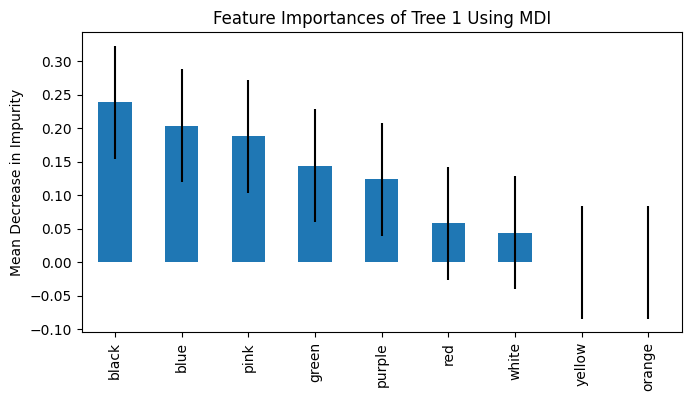

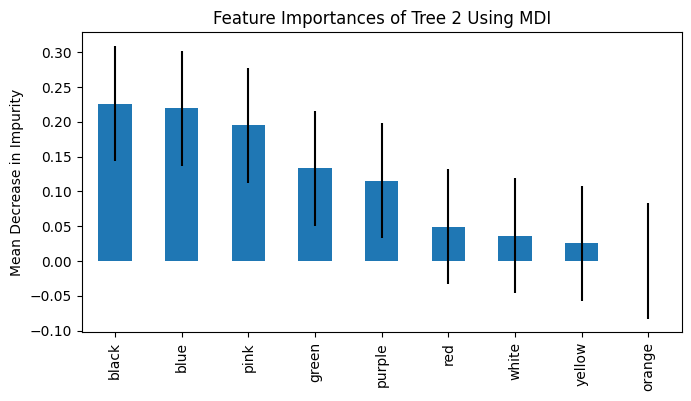

In [61]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_colors_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_colors_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

### Random Forest

In [37]:
# Create the RF model for image colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
rf_multi_hyperparameters = {
    "criterion": ['gini', ],    # 'entropy', 'log_loss'
    "n_estimators": range(100, 500, 100),
    "min_samples_split": range(2, 8, 2),
    "max_depth": list(range(10, 25, 5)) + [None, ],
    "class_weight": ["balanced", "balanced_subsample", ],
    "random_state": (RNG_SEED, ),
}

rf_colors_multi_model = MultiOutputClassifier(GridSearchCV(RandomForestClassifier(), rf_multi_hyperparameters, n_jobs=None), n_jobs=None)

rf_colors_multi_model = rf_colors_multi_model.fit(X_colors_train, y_colors_train)

In [38]:
rf_color_multi_pred = pd.DataFrame(rf_colors_multi_model.predict(X_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(rf_color_multi_pred, y_colors_test)
acc_both = both_accuracy_score(rf_color_multi_pred, y_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.2760416666666667
Both type accuracy: 0.015625


### Multi-Layer Perceptron Neural Network

In [ ]:
# Create the MLP model for image colors
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
mlp_multi_hyperparameters = {
    "activation": ('relu', ),
    "solver": ('adam', ),
    "learning_rate": ('constant', 'invscaling', ),
    "max_iter": range(4000, 4500, 500),
    "n_iter_no_change": range(4, 12, 2),
    "random_state": (RNG_SEED, ),
}

mlp_colors_model = MultiOutputClassifier(GridSearchCV(MLPClassifier(), mlp_multi_hyperparameters, n_jobs=None), n_jobs=None)
mlp_colors_model = mlp_colors_model.fit(X_colors_train, y_colors_train)

In [ ]:
mlp_colors_pred = pd.DataFrame(mlp_colors_model.predict(X_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(mlp_colors_pred, y_colors_test)
acc_both = both_accuracy_score(mlp_colors_pred, y_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Index(['Type 1 Pred', 'Type 2 Pred', 'Type 1', 'Type 2'], dtype='object')
Either type accuracy: 0.2708333333333333
Both type accuracy: 0.026041666666666668


## Clustering Pokemon by Image Color

### K-Means

In [ ]:
# Use n_clusters=5
from sklearn.cluster import KMeans

km_colors_model = KMeans(
    n_clusters=8,
    random_state=RNG_SEED,
)
km_colors_model = km_colors_model.fit(X_colors_train)

In [108]:
km_colors_pred = km_colors_model.predict(X_colors_test)

### K-Means Clustering Analysis

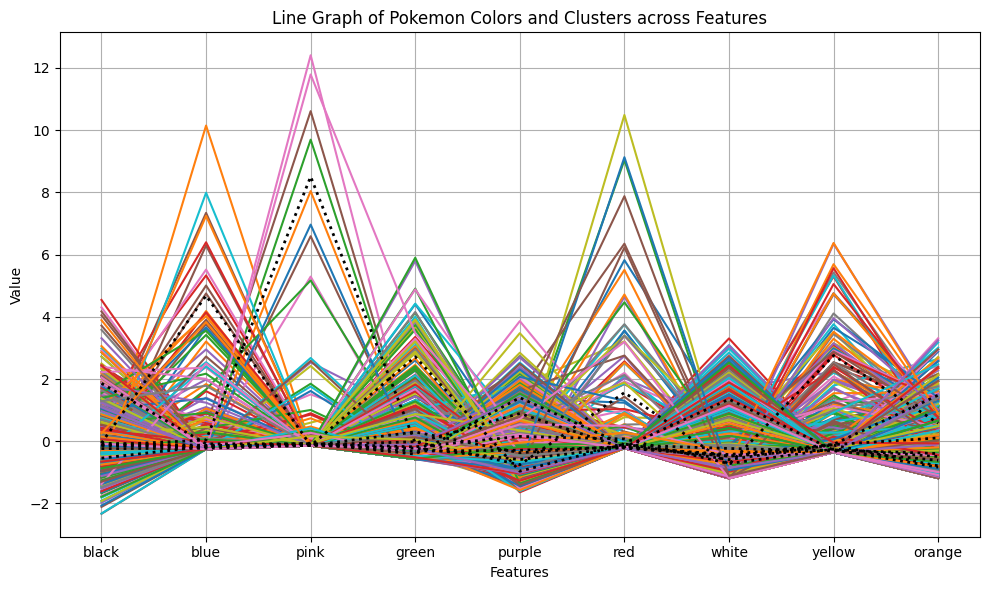

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = X_colors_train

plt.figure(figsize=(10, 6))
for idx in df.index:
    plt.plot(df.columns, df.loc[idx], label=f"Row {idx}")

for center in km_colors_model.cluster_centers_:
    plt.plot(df.columns, center, color="black", linestyle="dotted", linewidth=2)

plt.title("Line Graph of Pokemon Colors and Clusters across Features")
plt.xlabel("Features")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()